In [10]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
from arch.bootstrap import IIDBootstrap
from tqdm.notebook import tqdm
import statsmodels.formula.api as smf

# Creating ouput folders, if not present:
import pathlib
pathlib.Path('./outputs').mkdir(parents=True, exist_ok=True)
pathlib.Path('./figures').mkdir(parents=True, exist_ok=True)

# Setting seed for reproducibility; because of resampling. 
np.random.seed(1234)

# Define the list of indices
indices = ['SPY', 'VIX', 'VIXY', 'LQD_LQDH', 'GOVT', 'IVR', 'GOVT_TIP', 'GLD', 'JPY', 'EUR']

def bca_ols(data, hh):
    model = smf.ols(formula=f'M{hh} ~ emo + S_QASR0 + FFR + FG + AP + shadowrate + nopress', data=data)
    results = model.fit()
    return results.params

def bca_ols_nc(data, hh):
    model = smf.ols(formula=f'M{hh} ~ emo', data=data)
    results = model.fit()
    return results.params

def analyze_index(index):
    print(f"Starting with {index}")
    # Reading the data
    df = pd.read_stata(f'Main/data/est_{index}.dta')

    #### Binary Indicator Variable ####
    # returns True for elements that are not equal to 0 and False for elements that are equal to 0.
    # '.astype(int)' function is then applied to the boolean series. It converts True values to 1 and False values to 0
    df['pressconf'] = (df['countQA'] != 0).astype(int)
    df['nopress'] = (df['pressconf'] == 0).astype(int)

    #### Voice Tone ####
    # it selects the rows where the 'pressconf' column is equal to 0 and assigns the value 0 to the 'emo' column for those selected rows.
    df['emo'] = (df['pos'] - df['neg']) / (df['pos'] + df['neg'])
    df.loc[df['pressconf'] == 0, 'emo'] = 0

    #### Text Sentiment ####
    # Sentiment Analysis using Bert Embeddings
    # word embeddings (mappings of words to vectors of real numbers)
    # 𝑇𝑒𝑥𝑡𝑆𝑒𝑛𝑡𝑖𝑚𝑒𝑛𝑡 is in the range of [-1;1] and a positive value indicates that an expansionary monetary policy is expected or is being implemented.
    # To measure the totality of the sentiment, we compute 𝑇𝑒𝑥𝑡𝑆𝑒𝑛𝑡𝑖𝑚𝑒𝑛𝑡 using all three sources (statement, remarks, and Q&A responses).

    # (Policy) Statement
    df['S_statement'] = (df['dovish_s_bert'] - df['hawkish_s_bert']) / (df['dovish_s_bert'] + df['hawkish_s_bert'])

    # The following reads like it is measuring the totality of sentiment
    # QASR: Q&A_Statement_Remarks
    df['S_QASR'] = (df['dovish_bert'] - df['hawkish_bert'] + df['dovish_s_bert'] - df['hawkish_s_bert'] + df['dovish_r_bert'] - df['hawkish_r_bert']) / (df['dovish_bert'] + df['hawkish_bert'] + df['dovish_s_bert'] + df['hawkish_s_bert'] + df['dovish_r_bert'] + df['hawkish_r_bert'])
    df['S_QASR0'] = df['S_QASR']

    # Replace S_QASR0 with S_statement if pressconf is 0
    df.loc[df['pressconf'] == 0, 'S_QASR0'] = df['S_statement']

    #### Dependent Variable: Cumulative Returns ####
    # Calculate Cumulative Returns

    # Creating the M0 column
    df[f'M0'] = df[f'ret_{index}'] #f-string is used to create string template for the column names

    # Looping over 1 to 15 to create M1 to M15
    for hh in range(1, 16):  # Python range end is exclusive, so we use 16 to include 15
        hh1 = hh - 1  # Calculating hh1 as hh - 1, to create a variable for previous day
        df[f'M{hh}'] = df[f'M{hh1}'] + df[f'ret_{index}'].shift(-hh)

    # Filtering rows where fomc is 1
    df = df[df['fomc'] == 1]

    output = []

    for hh in tqdm(range(16), desc='Days'):

        model = smf.ols(formula=f'M{hh} ~ emo + S_QASR0 + FFR + FG + AP + shadowrate + nopress', data=df)
        results_orig = model.fit()
        
        bs = IIDBootstrap(df)
        results = bs.apply(func=bca_ols, reps=2000, extra_kwargs={'hh': hh})
        ci = bs.conf_int(func=bca_ols, reps=2000, method='bca', size=0.9, extra_kwargs={'hh': hh})
    
        # Variables in the order as they appear in 'results'
        variables = ['Intercept', 'emo', 'S_QASR0', 'FFR', 'FG', 'AP', 'shadowrate', 'nopress']
        
        row_output = {'hh': hh}
        for i, var in enumerate(variables):
            bias = np.mean(results[:, i])-(results_orig.params[i])
            row_output.update({
                f'bs_b_{var}': results_orig.params[i] - bias,
                f'bs_ll_{var}': ci[0, i],
                f'bs_ul_{var}': ci[1, i]
            })
        
        model_nc = smf.ols(formula=f'M{hh} ~ emo', data=df)
        results_orig_nc = model_nc.fit()
        
        bs_nc = IIDBootstrap(df)
        results_nc = bs_nc.apply(func=bca_ols_nc, reps=2000, extra_kwargs={'hh': hh})
        ci_nc = bs_nc.conf_int(func=bca_ols_nc, reps=2000, method='bca', size=0.9, extra_kwargs={'hh': hh})
    
        # Variables in the order as they appear in 'results'
        variables_nc = ['Intercept', 'emo']
        
        for i, var in enumerate(variables_nc):
            bias = np.mean(results_nc[:, i])-(results_orig_nc.params[i])
            row_output.update({
                f'bs_b_{var}_nc': results_orig_nc.params[i] - bias,
                f'bs_ll_{var}_nc': ci_nc[0, i],
                f'bs_ul_{var}_nc': ci_nc[1, i]
            })
    
        output.append(row_output)

    df_output = pd.DataFrame(output)
    df_output.to_csv(f'outputs/output_{index}.csv', index=False)
    # Plot
    variables = ['emo_nc', 'emo', 'S_QASR0', 'FFR', 'FG', 'AP']
    
    # color mapping for the variables
    color_mapping = {
        'emo_nc': 'dodgerblue',
        'emo': 'mediumblue',
        'S_QASR0': 'red',
        'FFR': 'black',
        'FG': 'seagreen',
        'AP': 'orange',
    }
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 9), facecolor='white')
    
    # Add an overall title for the whole figure with increased font size
    fig.suptitle(f"Response of {index} to policy actions and messages", fontsize=14)
    
    # Flatten the axs array for easy indexing
    axs = axs.flatten()
    
    # Loop over each variable to create a subplot for each one
    for i, var in enumerate(variables):
        ax = axs[i]
        ax.plot(df_output['hh'], df_output[f'bs_b_{var}'] * 100, marker='', color=color_mapping[var], linewidth=3, alpha=0.9)
        ax.fill_between(df_output['hh'], df_output[f'bs_ll_{var}'] * 100, df_output[f'bs_ul_{var}'] * 100, color='gainsboro', alpha=0.6)
    
        # Add a horizontal red line at y=0 with increased line width
        ax.axhline(0, color='red', linewidth=1.2)
        
        plot_title = {
            'emo_nc': 'Voice Tone(No Control)',
            'emo': 'Voice Tone',
            'S_QASR0': 'Text Sentiment',
            'FFR': 'FFR Shock',
            'FG': 'FG Shock',
            'AP': 'AP Shock',
        }.get(var, var)
        
        ax.set_title(f"{index}: {plot_title}", loc='center', fontsize=12)
        ax.set_xlabel("Days from FOMC press conference", fontsize=10)
        ax.set_ylabel("Basis points", fontsize=10)
        ax.grid(False)
        ax.set_facecolor('white')
    
    # Adjust the layout to make space for the overall title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the plot to a PNG file
    plt.savefig(f'figures/{index}_response.png')
    
    # Show the plot
    plt.show()

Days:   0%|          | 0/16 [00:00<?, ?it/s]

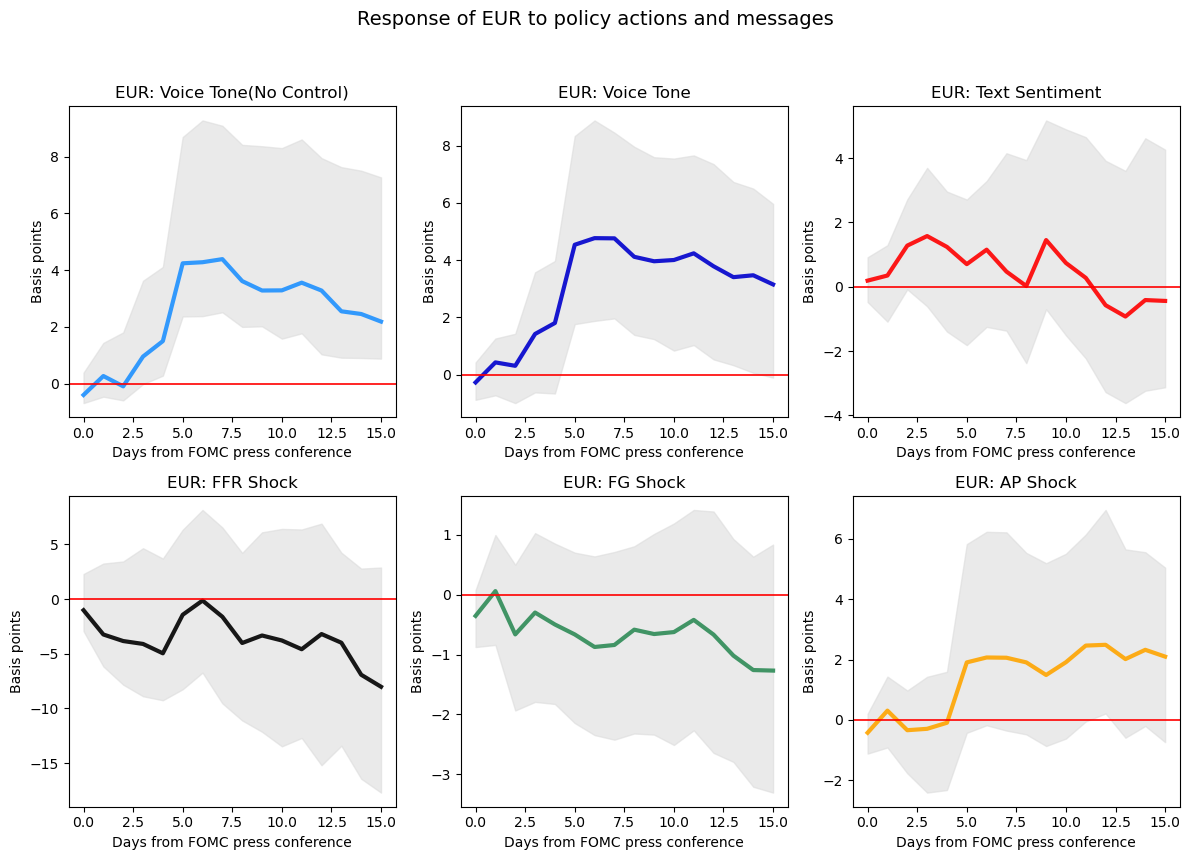

In [7]:
analyze_index("EUR")

Starting with SPY


Days:   0%|          | 0/16 [00:00<?, ?it/s]

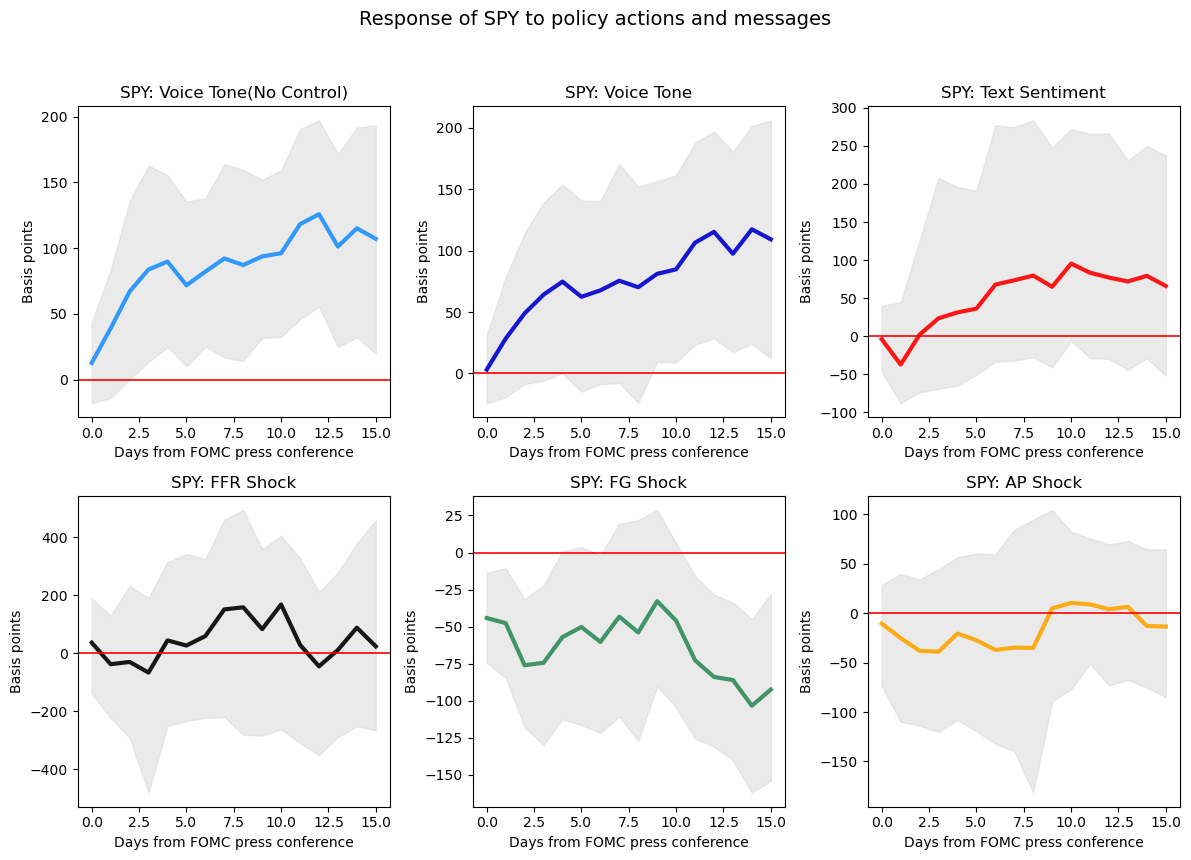

Starting with VIX


Days:   0%|          | 0/16 [00:00<?, ?it/s]

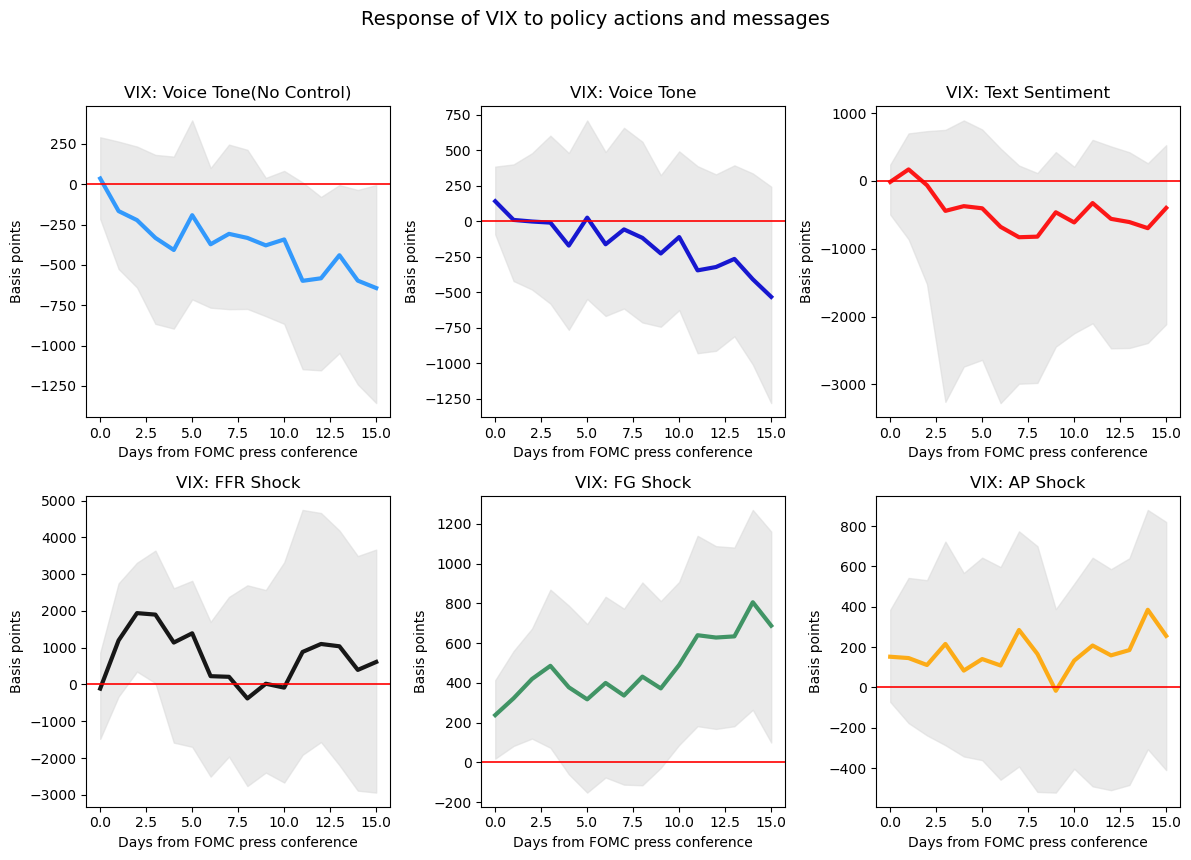

Starting with VIXY


Days:   0%|          | 0/16 [00:00<?, ?it/s]

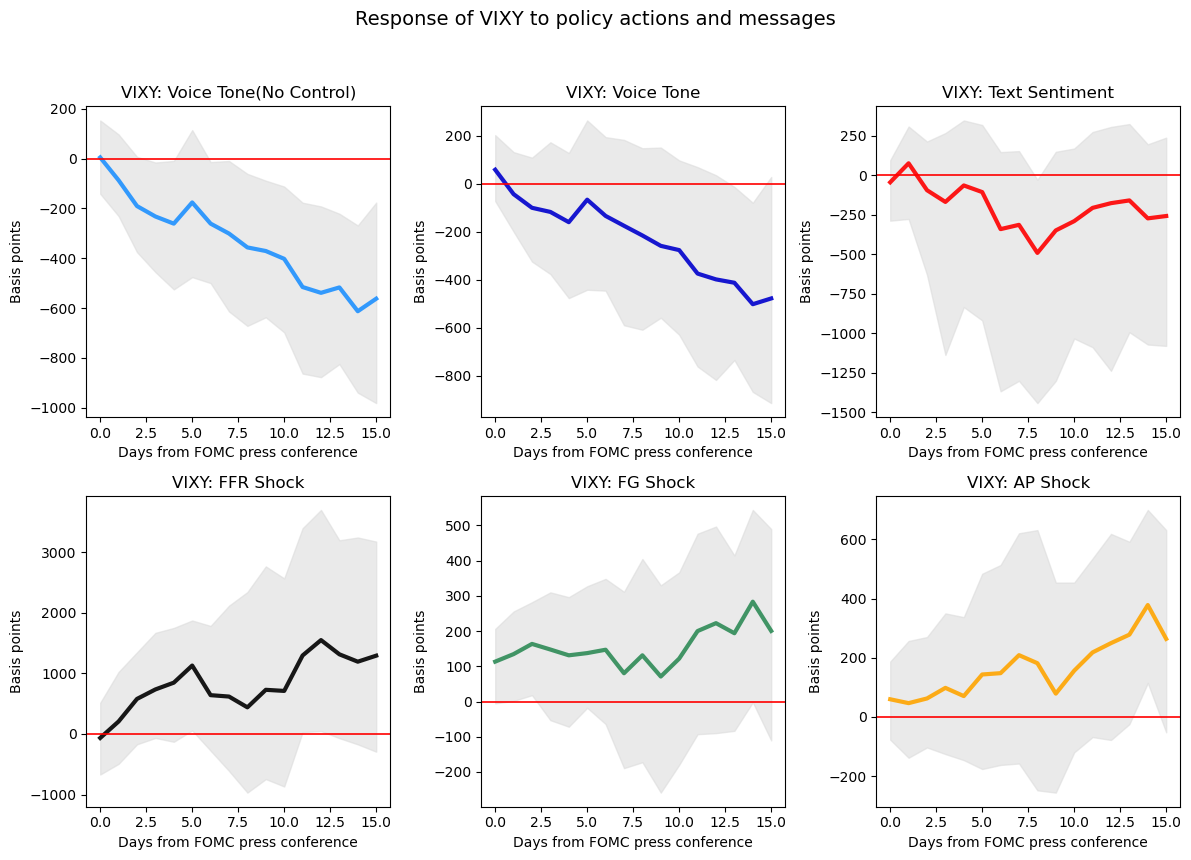

Starting with LQD_LQDH


Days:   0%|          | 0/16 [00:00<?, ?it/s]

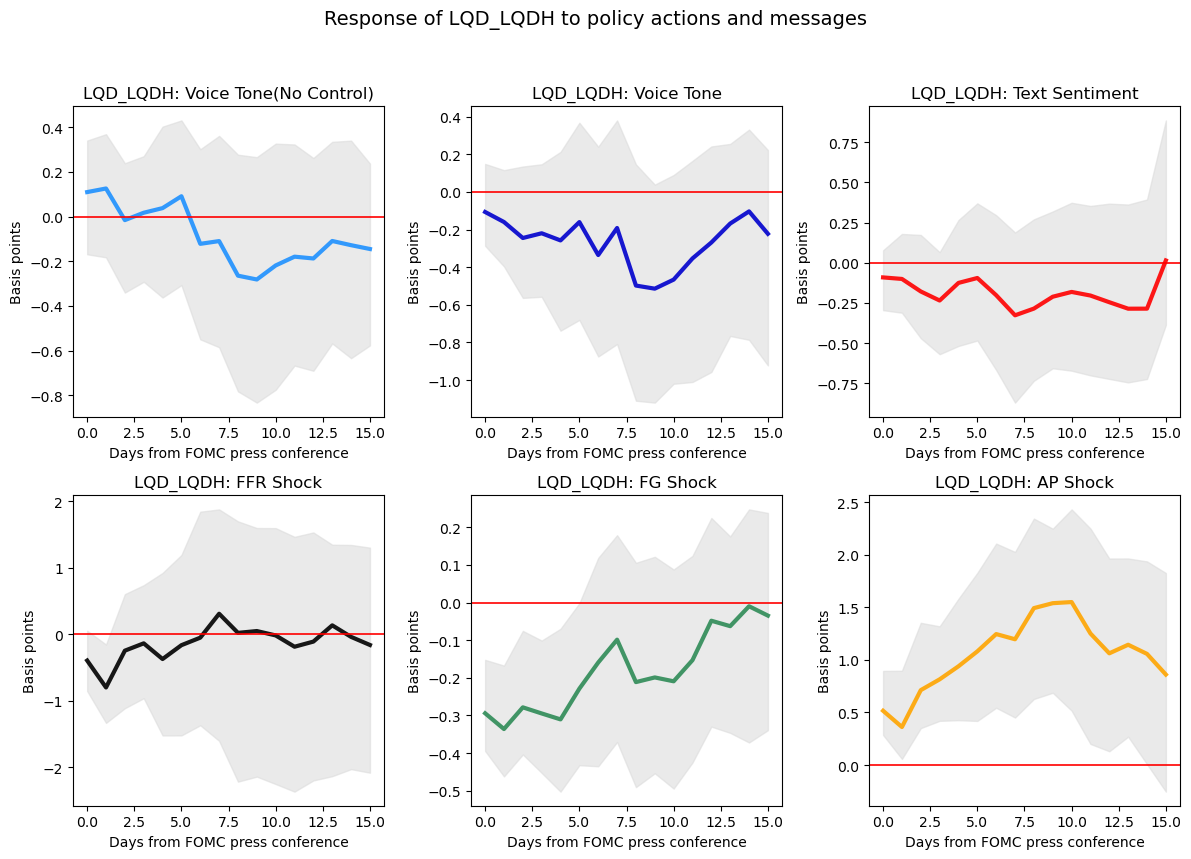

Starting with GOVT


Days:   0%|          | 0/16 [00:00<?, ?it/s]

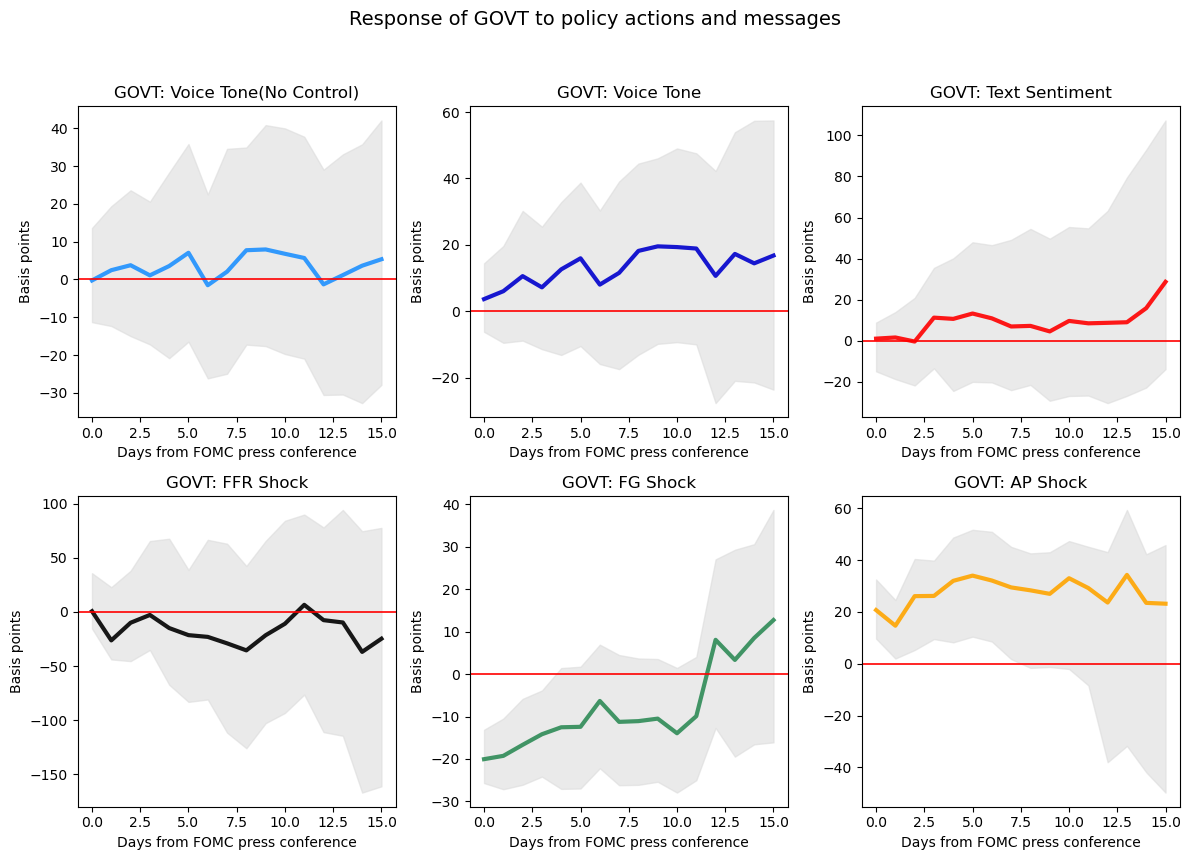

Starting with IVR


Days:   0%|          | 0/16 [00:00<?, ?it/s]

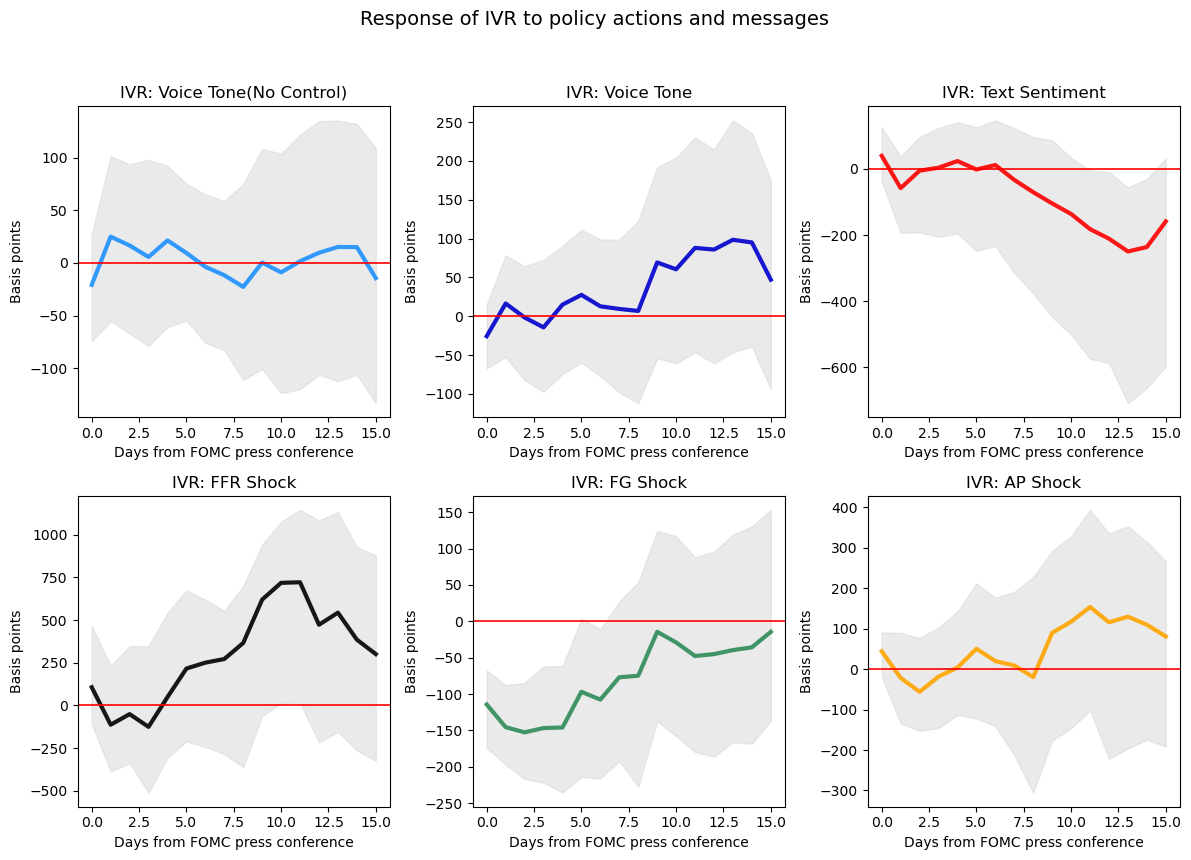

Starting with GOVT_TIP


Days:   0%|          | 0/16 [00:00<?, ?it/s]

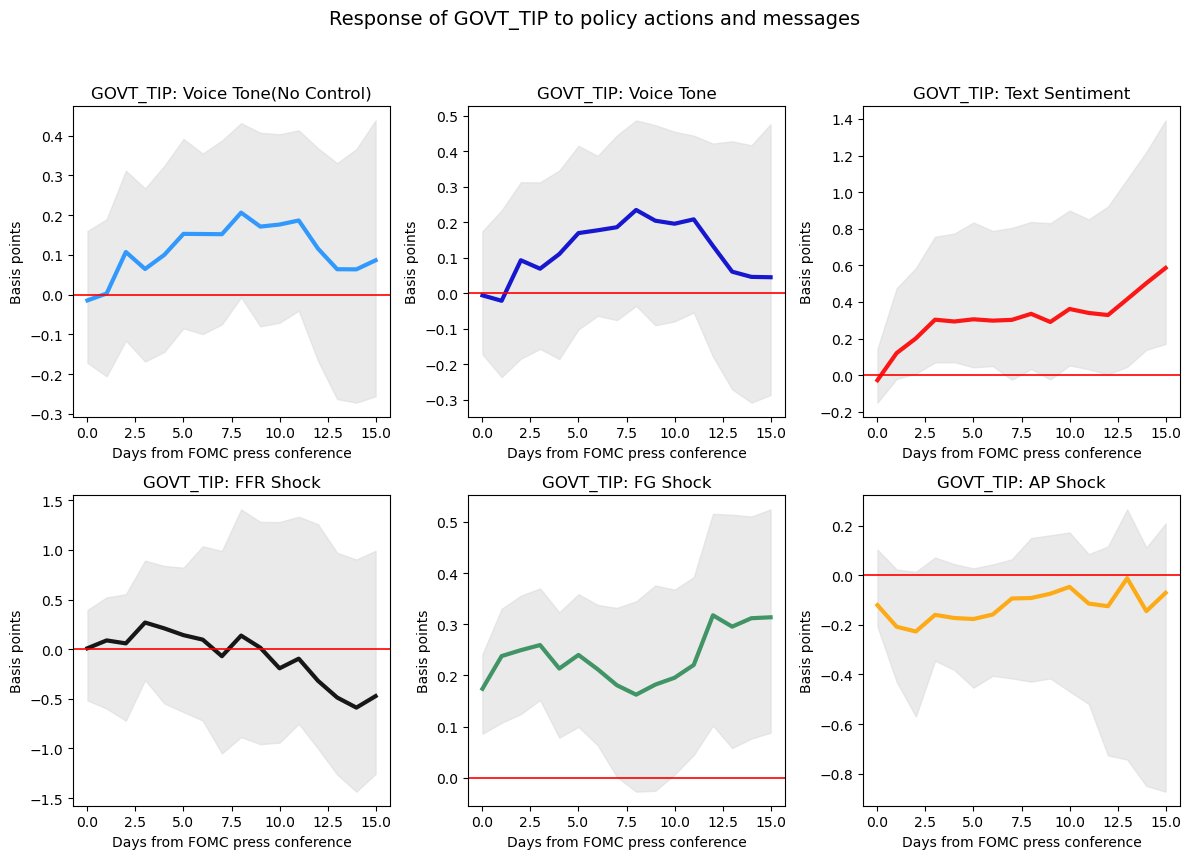

Starting with GLD


Days:   0%|          | 0/16 [00:00<?, ?it/s]

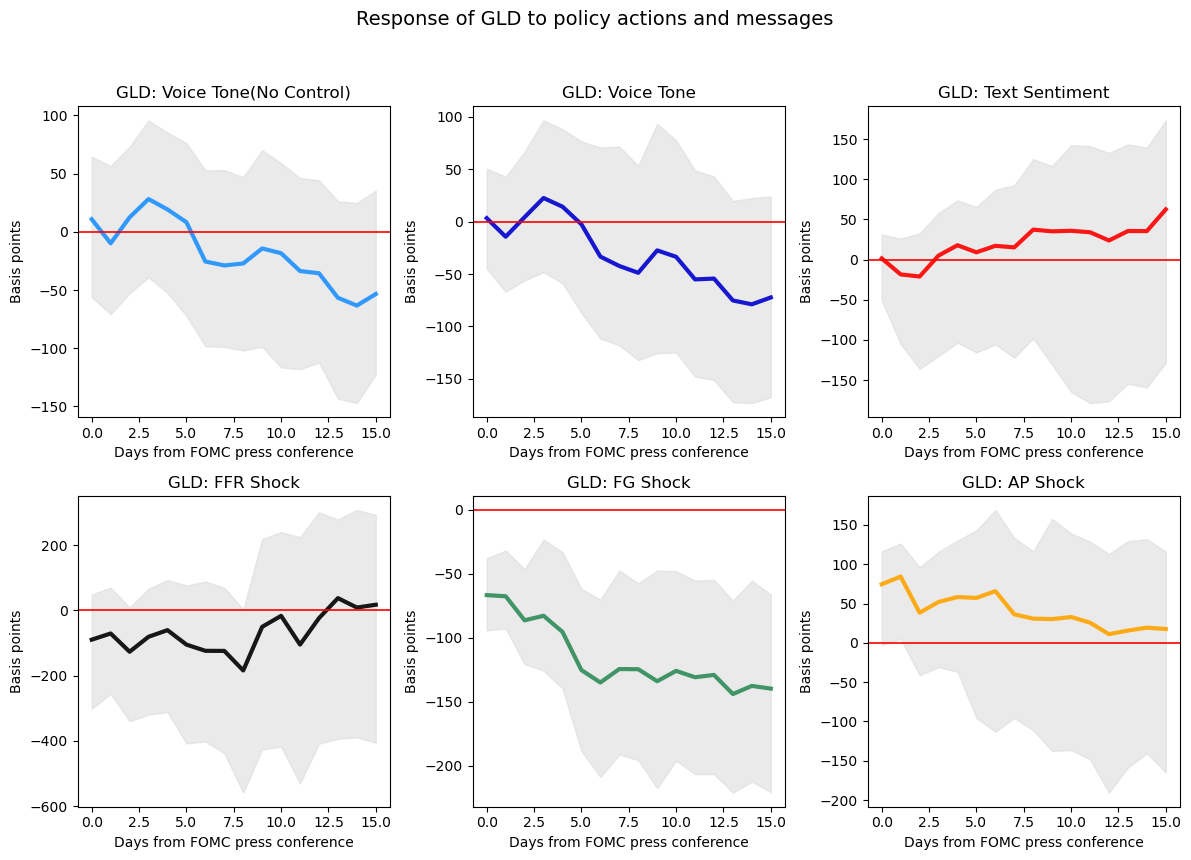

Starting with JPY


Days:   0%|          | 0/16 [00:00<?, ?it/s]

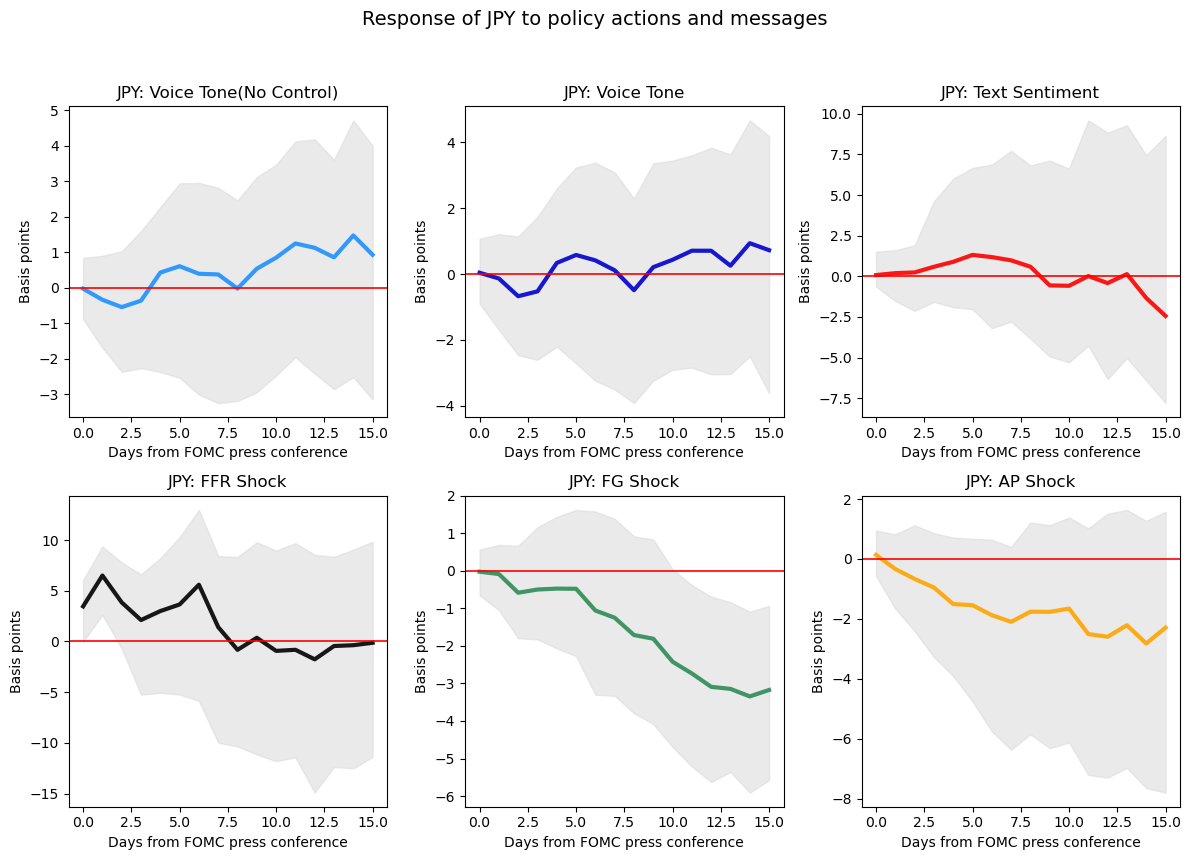

Starting with EUR


Days:   0%|          | 0/16 [00:00<?, ?it/s]

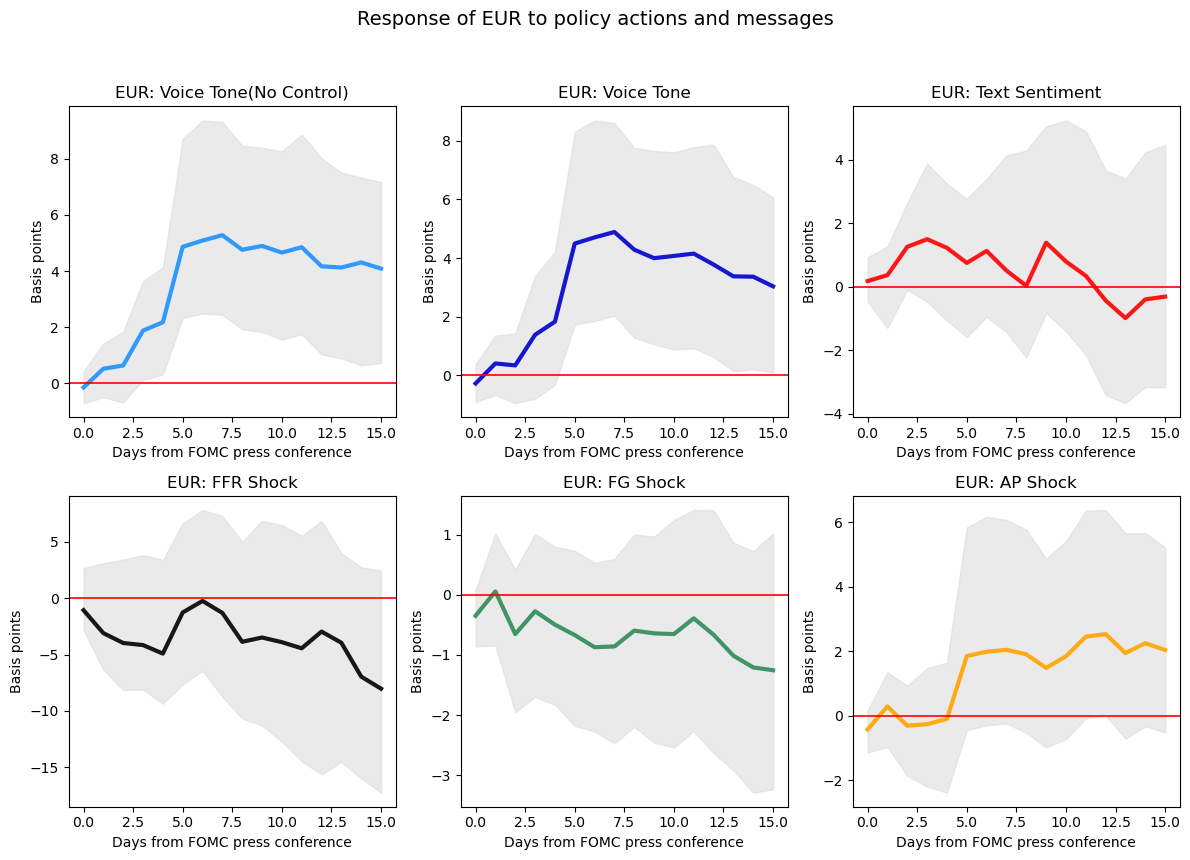

In [11]:
for index in indices:
    analyze_index(index)